In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import numba
import pandas as pd

### Defining Parameters:

In [2]:
weight = 8000                      #Weight of helicopter
blades = 4                         #Number of blades
V = 73                             #Forward velocity
rho = 1.215                        #Density
rpm = 260                          #Rotor RPM
omega = 2*np.pi*rpm/60             #radian/second
plate_area = 6.8                   #Flat plate area
R = 7.3                            #Radius
Rrc = 0.9                          #Root cut out
C = 0.55                           #Taper Length
a=5.8                              #coefficient of lift

In [3]:
solidity = (blades*C)/(np.pi*R)

#### Finding Drag and Alpha TPP 

In [4]:
def drag(Cd_fuselage):
    return 1.2*(0.5*rho*(V**2)*plate_area*Cd_fuselage) #1.2 for 20% extra drag taken

def alpha_tpp(Drag):
    return math.atan(Drag/(weight*9.81))

In [5]:
Cd_fuselage = 0.8
Drag = drag(0.8)
Alpha_tpp = alpha_tpp(Drag)

#### Discretization

In [6]:
#Discretize radius into 2000 parts
dr = np.zeros(2000)
for i in range(2000):
    dr[i] = Rrc + i*(R-Rrc)/2000
    
#Similarly for psi, we divide into 360 equal parts
dpsi = np.zeros(360)
for i in range(360):
    dpsi[i] = i*np.pi/180
    
# We will use these discretized values for whole assignment 
# dr is list of discretized r (2000 points)
# dpsi is list of discritized psi (360 points)

# Task1: Glauert Model

### 1. Finding Thrust and CT values

In [7]:
#Calculate CT
Thrust = (weight*9.81)/np.cos(Alpha_tpp)
CT = Thrust/(rho*np.pi*(R**2)*((omega*R)**2))
print(CT)

0.010114376284372516


### 2. Finding $ \lambda_{i,g}$ , $ \lambda_i$ and $\lambda$

In [8]:
# Advance ratio 
mu = (V*np.cos(Alpha_tpp))/(omega*R)

In [9]:
#Function for finding the 𝜆𝑖,𝑔   
def find_lamda_ig():
    tmp_lamda_ig = CT/(2*mu)
    err = 100

    while err > 10**-8:
        lamda_ig = CT/(2*np.sqrt(mu**2 + (mu*np.tan(Alpha_tpp) + tmp_lamda_ig)**2))
        err = abs(tmp_lamda_ig-lamda_ig)
        tmp_lamda_ig = lamda_ig
        
    return tmp_lamda_ig

In [10]:
lamda_ig = find_lamda_ig()
lamda_ig

0.01362910537056813

In [11]:
#function for finding the lambda_G
def find_lamda_G():
    tmp = (V*np.sin(Alpha_tpp))/(omega*R)
    return lamda_ig+tmp

In [12]:
lamda_G = find_lamda_G()

In [13]:
#Function for finding the lambda_i/lambda_ig
@numba.njit
def find_ratio_i_ig(r,psi):
    tmp = ((4*mu)/(3*lamda_G)/(1.2+mu/lamda_G))*(r*np.cos(psi)/R)
    return 1+tmp

In [14]:
#For total inflow
@numba.njit
def find_lamda(r,psi):
    tmp_a = (V*np.sin(Alpha_tpp))/(omega*R)
    tmp_b = lamda_ig*find_ratio_i_ig(r,psi)
    return tmp_a + tmp_b

### 3. Finding Pitch ($\theta $), Flap ($ \beta$), Angle of attack ($\alpha$)

##### 3.1 Pitch 

In [15]:
# These are values after finding Trim , optimization is in latter part of notebook
theta_0 = 18.7
theta_tw = -0.3
theta_1c = 2.1
theta_1s = -11.2
theta_0 = theta_0*np.pi/180
theta_tw = theta_tw*np.pi/180
theta_1c = theta_1c*np.pi/180
theta_1s = theta_1s*np.pi/180

In [16]:
#function for calculating pitch
@numba.njit
def pitch(r,psi,theta_0=theta_0, theta_1c=theta_1c, theta_1s=theta_1s,theta_tw=theta_tw):
    theta = theta_0 + theta_1c*np.cos(psi) + theta_1s*np.sin(psi) + theta_tw*(r/R)
    return theta


##### 3.2 Flap

In [17]:
# These are values after finding Trim , optimization is in latter part of notebook
beta_0 = 3
beta_1c = -1.07
beta_1s = 1.68
beta_0 = beta_0*np.pi/180
beta_1c = beta_1c*np.pi/180
beta_1s = beta_1s*np.pi/180

In [18]:
@numba.njit
def Flap(psi,beta_0=beta_0, beta_1c=beta_1c,beta_1s=beta_1s):
    beta = beta_0 + beta_1c*np.cos(psi) + beta_1s*np.sin(psi)
    return beta

##### 3.3 Angle of Attack

In [19]:
@numba.njit
def angle_of_attack(r,psi,beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw):
    UT = omega*r + V*np.cos(Alpha_tpp)*np.sin(psi)
    UP = find_lamda(r,psi)*omega*R*np.cos(Flap(psi,beta_0, beta_1c,beta_1s)) + V*np.cos(Alpha_tpp)*np.sin(Flap(psi,beta_0, beta_1c,beta_1s))*np.cos(psi)
    theta = pitch(r,psi,theta_0, theta_1c, theta_1s,theta_tw)
    return theta - np.arctan(UP/UT)

### 4. Find Thrust, Pitch Moment, Rolling Moment

##### 4.1 Thrust

In [20]:
#Function for calculating L_prime at given r and psi (L_prime as described in lectures)
@numba.njit
def L_prime(r,psi,beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw):
    Cl = a*angle_of_attack(r,psi,beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw)
    UT = omega*r + V*np.cos(Alpha_tpp)*np.sin(psi)
    UP = find_lamda(r,psi)*omega*R*np.cos(Flap(psi,beta_0, beta_1c,beta_1s)) + V*np.cos(Alpha_tpp)*np.sin(Flap(psi,beta_0, beta_1c,beta_1s))*np.cos(psi)
    #print(Flap(psi))
    ans = 0.5*rho*C*Cl*(UT**2 + UP**2)*np.sign(UT)
    return ans

In [21]:
#Total Thrust:
@numba.njit
def find_Thrust(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw):
    thrust_dr = np.zeros(len(dr))
    for i in range(len(dr)):
        thrust_dpsi = np.zeros(len(dpsi))
        for j in range(len(dpsi)):
            thrust_dpsi[j] = L_prime(dr[i],dpsi[j],beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw)
        thrust_dr[i] = ((2*np.pi)/(len(dpsi)*2))*(thrust_dpsi[0]+thrust_dpsi[-1]+2*np.sum(thrust_dpsi[1:-1]))

    Total_Thrust = ((R-Rrc)/(len(dr)*2))*(thrust_dr[0]+thrust_dr[-1]+2*np.sum(thrust_dr[1:-1]))
    return Total_Thrust
      

In [22]:
Total_Thrust = blades*find_Thrust(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw)/(2*np.pi)
CT_integrate = Total_Thrust/(rho*(omega**2)*(R**4)*np.pi)
print('Total_Thrust: ',Total_Thrust)
print('CT_integrate: ',CT_integrate)

Total_Thrust:  83162.49352881065
CT_integrate:  0.010349180931778517


In [23]:
## Also Same by using Scipy integrate function

In [81]:
from scipy import integrate
f = lambda psi,r:L_prime(r,psi,beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw)
Total_Thrust_scipy = integrate.dblquad(f,Rrc,R,lambda r:0,lambda r:2*np.pi)[0]

In [25]:
Total_Thrust_scipy = blades*Total_Thrust_scipy/(2*np.pi)
CT_integrate_scipy = Total_Thrust_scipy/(rho*(omega**2)*(R**4)*np.pi)
print('Total_Thrust: ',Total_Thrust_scipy)
print('CT_integrate: ',CT_integrate_scipy)

Total_Thrust:  83686.4446494264
CT_integrate:  0.010414384182866483


##### 4.2 Rolling Moment

In [26]:
#Rolling moment
@numba.njit
def find_rolling_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw):
    rolling_dr = np.zeros(len(dr))
    for i in range(len(dr)):
        rolling_dpsi = np.zeros(len(dpsi))
        for j in range(len(dpsi)):
            rolling_dpsi[j] = L_prime(dr[i],dpsi[j],beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw)*dr[i]*np.sin(dpsi[j])
        rolling_dr[i] = ((2*np.pi)/(len(dpsi)*2))*(rolling_dpsi[0]+rolling_dpsi[-1]+2*np.sum(rolling_dpsi[1:-1]))

    Total_rolling_moment = ((R-Rrc)/(len(dr)*2))*(rolling_dr[0]+rolling_dr[-1]+2*np.sum(rolling_dr[1:-1]))
    return Total_rolling_moment

In [27]:
Rolling_moment = blades*find_rolling_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw)/(2*np.pi)
C_rolling = Rolling_moment/(rho*(omega**2)*(R**5)*np.pi)
print('Rolling Moment: ',Rolling_moment)
print('Cm_rolling: ',C_rolling)

Rolling Moment:  -34.80656785539928
Cm_rolling:  -5.933580218293491e-07


###### 4.3 Pitching Moment

In [28]:
#Pitching Moment:
@numba.njit
def find_pitching_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw):
    pitching_dr = np.zeros(len(dr))
    for i in range(len(dr)):
        pitching_dpsi = np.zeros(len(dpsi))
        for j in range(len(dpsi)):
            pitching_dpsi[j] = L_prime(dr[i],dpsi[j],beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw)*dr[i]*np.cos(dpsi[j])
        pitching_dr[i] = ((2*np.pi)/(len(dpsi)*2))*(pitching_dpsi[0]+pitching_dpsi[-1]+2*np.sum(pitching_dpsi[1:-1]))

    Total_pitching_moment = ((R-Rrc)/(len(dr)*2))*(pitching_dr[0]+pitching_dr[-1]+2*np.sum(pitching_dr[1:-1]))
    return Total_pitching_moment
      

In [29]:
Pitching_moment = blades*find_pitching_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw)/(2*np.pi)
C_pitching = Pitching_moment/(rho*(omega**2)*(R**5)*np.pi)
print('Pitching Moment: ',Pitching_moment)
print('C_pitching: ',C_pitching)

Pitching Moment:  13.289264550257442
C_pitching:  2.265460862980337e-07


### 5. Find trim conditios 

In [30]:
# We will here try to find trim values of θo, βo, β1c + θ1s and β1s - θ1c

##### 5.1 Find βo trim values

In [31]:
#We will vary βo keeping other values constant
beta_0_list = np.array([1,2,3,4,5,6])*np.pi/180

##Other values we will choose some appropriate values:

beta_1c = -2*np.pi/180
beta_1s = 2*np.pi/180

theta_0 = 18*np.pi/180
theta_tw = -0.3*np.pi/180
theta_1c = 2*np.pi/180
theta_1s = -11*np.pi/180



In [32]:
CT_beta_0=[]
Cm_roll_beta_0=[]
Cm_pitch_beta_0=[]
for i in beta_0_list:
    beta_0 = i
    CT_tmp = (blades*find_Thrust(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*(rho*(omega**2)*(R**4)*np.pi))
    #print(CT_tmp)
    CM_roll_tmp= (blades*find_rolling_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*rho*(omega**2)*(R**5)*np.pi)
    #print(CM_roll_tmp)
    CM_pitch_tmp = (blades*find_pitching_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*rho*(omega**2)*(R**5)*np.pi)
    CT_beta_0.append(CT_tmp)
    Cm_roll_beta_0.append(CM_roll_tmp)
    Cm_pitch_beta_0.append(CM_pitch_tmp)

In [33]:
beta0_table = pd.DataFrame(columns=['beta0','CT','Cm,pitch','Cm,roll'],index=np.arange(len(beta_0_list)))

In [34]:
beta0_table['beta0']=beta_0_list*180/np.pi
beta0_table['CT']=CT_beta_0
beta0_table['Cm,pitch']=Cm_pitch_beta_0
beta0_table['Cm,roll']=Cm_roll_beta_0

In [35]:
beta0_table

,beta0,CT,"Cm,pitch","Cm,roll"
0,1.0,0.009552,0.000472,-0.000229
1,2.0,0.009566,0.000193,-0.000225
2,3.0,0.009582,-0.000086,-0.000221
3,4.0,0.009600,-0.000365,-0.000215
4,5.0,0.009622,-0.000643,-0.000208
5,6.0,0.009646,-0.000922,-0.000201


##### 5.2  Find β1c trim values

In [36]:
#We will vary β1c keeping other values constant
beta_1c_list = np.array([-1,-2,-3,-4,-5,-6])*np.pi/180

##Other values we will choose some appropriate values:
beta_0 = 3*np.pi/180
beta_1s = 2*np.pi/180

theta_0 = 18*np.pi/180
theta_tw = -0.3*np.pi/180
theta_1c = 2*np.pi/180
theta_1s = -11*np.pi/180




In [37]:
CT_beta_1c=[]
Cm_roll_beta_1c=[]
Cm_pitch_beta_1c=[]
for i in beta_1c_list:
    beta_1c = i
    CT_tmp = (blades*find_Thrust(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*(rho*(omega**2)*(R**4)*np.pi))
    #print(CT_tmp)
    CM_roll_tmp= (blades*find_rolling_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*rho*(omega**2)*(R**5)*np.pi)
    #print(CM_roll_tmp)
    CM_pitch_tmp = (blades*find_pitching_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*rho*(omega**2)*(R**5)*np.pi)
    CT_beta_1c.append(CT_tmp)
    Cm_roll_beta_1c.append(CM_roll_tmp)
    Cm_pitch_beta_1c.append(CM_pitch_tmp)

In [38]:
beta_1c_table = pd.DataFrame(columns=['beta_1c','CT','Cm,pitch','Cm,roll'],index=np.arange(len(beta_1c_list)))

In [39]:
beta_1c_table['beta_1c']=beta_1c_list*180/np.pi
beta_1c_table['CT']=CT_beta_1c
beta_1c_table['Cm,pitch']=Cm_pitch_beta_1c
beta_1c_table['Cm,roll']=Cm_roll_beta_1c

In [40]:
beta_1c_table

,beta_1c,CT,"Cm,pitch","Cm,roll"
0,-1.0,0.009155,-0.000079,-0.000258
1,-2.0,0.009582,-0.000086,-0.000221
2,-3.0,0.010009,-0.000093,-0.000183
3,-4.0,0.010437,-0.000101,-0.000146
4,-5.0,0.010867,-0.000108,-0.000108
5,-6.0,0.011297,-0.000115,-0.000070


##### 5.3  Find β1s trim values

In [41]:
#We will vary β1s keeping other values constant
beta_1s_list = np.array([1,2,3,4,5,6])*np.pi/180


##Other values we will choose some appropriate values:

beta_0 = 3*np.pi/180
beta_1c= -2*np.pi/180

theta_0 = 18*np.pi/180
theta_tw = -0.3*np.pi/180
theta_1c = 2*np.pi/180
theta_1s = -11*np.pi/180

In [42]:
CT_beta_1s=[]
Cm_roll_beta_1s=[]
Cm_pitch_beta_1s=[]
for i in beta_1s_list:
    beta_1s = i
    CT_tmp = (blades*find_Thrust(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*(rho*(omega**2)*(R**4)*np.pi))
    #print(CT_tmp)
    CM_roll_tmp= (blades*find_rolling_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*rho*(omega**2)*(R**5)*np.pi)
    #print(CM_roll_tmp)
    CM_pitch_tmp = (blades*find_pitching_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*rho*(omega**2)*(R**5)*np.pi)
    CT_beta_1s.append(CT_tmp)
    Cm_roll_beta_1s.append(CM_roll_tmp)
    Cm_pitch_beta_1s.append(CM_pitch_tmp)

In [43]:
beta_1s_table = pd.DataFrame(columns=['beta_1s','CT','Cm,pitch','Cm,roll'],index=np.arange(len(beta_1s_list)))

In [44]:
beta_1s_table['beta_1s']=beta_1s_list*180/np.pi
beta_1s_table['CT']=CT_beta_1s
beta_1s_table['Cm,pitch']=Cm_pitch_beta_1s
beta_1s_table['Cm,roll']=Cm_roll_beta_1s

In [45]:
beta_1s_table

,beta_1s,CT,"Cm,pitch","Cm,roll"
0,1.0,0.009573,-0.000049,-0.000226
1,2.0,0.009582,-0.000086,-0.000221
2,3.0,0.009592,-0.000123,-0.000214
3,4.0,0.009604,-0.000160,-0.000208
4,5.0,0.009617,-0.000197,-0.000200
5,6.0,0.009632,-0.000234,-0.000192


##### 5.4  Find θo trim values

In [46]:
#We will vary θo keeping other values constant
theta_0_list = np.array([15,16,17,18,19,20])*np.pi/180

##Other values we will choose some appropriate values:

beta_0 = 3*np.pi/180
beta_1c= -2*np.pi/180
beta_1s= 2*np.pi/180

theta_tw = -0.3*np.pi/180
theta_1c = 2*np.pi/180
theta_1s = -11*np.pi/180

In [47]:
CT_theta_0=[]
Cm_roll_theta_0=[]
Cm_pitch_theta_0=[]
for i in theta_0_list:
    theta_0 = i
    CT_tmp = (blades*find_Thrust(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*(rho*(omega**2)*(R**4)*np.pi))
    #print(CT_tmp)
    CM_roll_tmp= (blades*find_rolling_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*rho*(omega**2)*(R**5)*np.pi)
    #print(CM_roll_tmp)
    CM_pitch_tmp = (blades*find_pitching_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*rho*(omega**2)*(R**5)*np.pi)
    CT_theta_0.append(CT_tmp)
    Cm_roll_theta_0.append(CM_roll_tmp)
    Cm_pitch_theta_0.append(CM_pitch_tmp)

In [48]:
theta_0_table = pd.DataFrame(columns=['theta_0','CT','Cm,pitch','Cm,roll'],index=np.arange(len(theta_0_list)))

In [49]:
theta_0_table['theta_0']=theta_0_list*180/np.pi
theta_0_table['CT']=CT_theta_0
theta_0_table['Cm,pitch']=Cm_pitch_theta_0
theta_0_table['Cm,roll']=Cm_roll_theta_0

In [50]:
theta_0_table

,theta_0,CT,"Cm,pitch","Cm,roll"
0,15.0,0.003853,-0.000095,-0.001945
1,16.0,0.005762,-0.000092,-0.001370
2,17.0,0.007672,-0.000089,-0.000795
3,18.0,0.009582,-0.000086,-0.000221
4,19.0,0.011491,-0.000083,0.000354
5,20.0,0.013401,-0.000080,0.000929


##### 5.5 Find θtw trim values

In [51]:
#We will vary θtw keeping other values constant
theta_tw_list = np.array([-0.1,-0.2,-0.3,-0.4,-0.5,-0.6])*np.pi/180

##Other values we will choose some appropriate values:

beta_0 = 3*np.pi/180
beta_1c= -2*np.pi/180
beta_1s= 2*np.pi/180

theta_0=18*np.pi/180
theta_1c = 2*np.pi/180
theta_1s = -11*np.pi/180

In [52]:
CT_theta_tw=[]
Cm_roll_theta_tw=[]
Cm_pitch_theta_tw=[]
for i in theta_tw_list:
    theta_tw = i
    CT_tmp = (blades*find_Thrust(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*(rho*(omega**2)*(R**4)*np.pi))
    #print(CT_tmp)
    CM_roll_tmp= (blades*find_rolling_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*rho*(omega**2)*(R**5)*np.pi)
    #print(CM_roll_tmp)
    CM_pitch_tmp = (blades*find_pitching_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*rho*(omega**2)*(R**5)*np.pi)
    CT_theta_tw.append(CT_tmp)
    Cm_roll_theta_tw.append(CM_roll_tmp)
    Cm_pitch_theta_tw.append(CM_pitch_tmp)

In [53]:
theta_tw_table = pd.DataFrame(columns=['theta_tw','CT','Cm,pitch','Cm,roll'],index=np.arange(len(theta_tw_list)))

In [54]:
theta_tw_table['theta_tw']=theta_tw_list*180/np.pi
theta_tw_table['CT']=CT_theta_tw
theta_tw_table['Cm,pitch']=Cm_pitch_theta_tw
theta_tw_table['Cm,roll']=Cm_roll_theta_tw

In [55]:
theta_tw_table

,theta_tw,CT,"Cm,pitch","Cm,roll"
0,-0.1,0.009858,-0.000086,-0.000134
1,-0.2,0.009720,-0.000086,-0.000177
2,-0.3,0.009582,-0.000086,-0.000221
3,-0.4,0.009443,-0.000086,-0.000264
4,-0.5,0.009305,-0.000086,-0.000307
5,-0.6,0.009167,-0.000087,-0.000350


##### 5.6 Find θ1c trim values

In [56]:
#We will vary θ1c keeping other values constant
theta_1c_list = np.array([1,2,3,4,5,6])*np.pi/180

##Other values we will choose some appropriate values:

beta_0 = 3*np.pi/180
beta_1c= -2*np.pi/180
beta_1s= 2*np.pi/180

theta_0=18*np.pi/180
theta_tw = -0.3*np.pi/180
theta_1s = -11*np.pi/180

In [57]:
CT_theta_1c=[]
Cm_roll_theta_1c=[]
Cm_pitch_theta_1c=[]
for i in theta_1c_list:
    theta_1c = i
    CT_tmp = (blades*find_Thrust(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*(rho*(omega**2)*(R**4)*np.pi))
    #print(CT_tmp)
    CM_roll_tmp= (blades*find_rolling_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*rho*(omega**2)*(R**5)*np.pi)
    #print(CM_roll_tmp)
    CM_pitch_tmp = (blades*find_pitching_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*rho*(omega**2)*(R**5)*np.pi)
    CT_theta_1c.append(CT_tmp)
    Cm_roll_theta_1c.append(CM_roll_tmp)
    Cm_pitch_theta_1c.append(CM_pitch_tmp)

In [58]:
theta_1c_table = pd.DataFrame(columns=['theta_1c','CT','Cm,pitch','Cm,roll'],index=np.arange(len(theta_1c_list)))

In [59]:
theta_1c_table['theta_1c']=theta_1c_list*180/np.pi
theta_1c_table['CT']=CT_theta_1c
theta_1c_table['Cm,pitch']=Cm_pitch_theta_1c
theta_1c_table['Cm,roll']=Cm_roll_theta_1c

In [60]:
theta_1c_table

,theta_1c,CT,"Cm,pitch","Cm,roll"
0,1.0,0.009576,-0.000738,-0.000221
1,2.0,0.009582,-0.000086,-0.000221
2,3.0,0.009588,0.000566,-0.000220
3,4.0,0.009594,0.001218,-0.000219
4,5.0,0.009600,0.001870,-0.000218
5,6.0,0.009606,0.002522,-0.000217


##### 5.7 Find θ1s trim values

In [61]:
#We will vary θ1s keeping other values constant
theta_1s_list = np.array([-9,-10,-11,-12,-13,-14])*np.pi/180

##Other values we will choose some appropriate values:

beta_0 = 3*np.pi/180
beta_1c= -2*np.pi/180
beta_1s= 2*np.pi/180

theta_0=18*np.pi/180
theta_tw = -0.3*np.pi/180
theta_1c = 2*np.pi/180

In [62]:
CT_theta_1s=[]
Cm_roll_theta_1s=[]
Cm_pitch_theta_1s=[]
for i in theta_1s_list:
    theta_1s = i
    CT_tmp = (blades*find_Thrust(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*(rho*(omega**2)*(R**4)*np.pi))
    #print(CT_tmp)
    CM_roll_tmp= (blades*find_rolling_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*rho*(omega**2)*(R**5)*np.pi)
    #print(CM_roll_tmp)
    CM_pitch_tmp = (blades*find_pitching_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw))/(2*np.pi*rho*(omega**2)*(R**5)*np.pi)
    CT_theta_1s.append(CT_tmp)
    Cm_roll_theta_1s.append(CM_roll_tmp)
    Cm_pitch_theta_1s.append(CM_pitch_tmp)

In [63]:
theta_1s_table = pd.DataFrame(columns=['theta_1s','CT','Cm,pitch','Cm,roll'],index=np.arange(len(theta_1s_list)))

In [64]:
theta_1s_table['theta_1s']=theta_1s_list*180/np.pi
theta_1s_table['CT']=CT_theta_1s
theta_1s_table['Cm,pitch']=Cm_pitch_theta_1s
theta_1s_table['Cm,roll']=Cm_roll_theta_1s

In [65]:
theta_1s_table

,theta_1s,CT,"Cm,pitch","Cm,roll"
0,-9.0,0.011300,-0.000084,0.001239
1,-10.0,0.010441,-0.000085,0.000509
2,-11.0,0.009582,-0.000086,-0.000221
3,-12.0,0.008722,-0.000087,-0.000950
4,-13.0,0.007863,-0.000088,-0.001680
5,-14.0,0.007004,-0.000089,-0.002410


##### 5.8 Final Trim Values 

In [66]:
# These are final trim values after optimization
beta_0 = 3
beta_1c = -1.07
beta_1s = 1.68
beta_0 = beta_0*np.pi/180
beta_1c = beta_1c*np.pi/180
beta_1s = beta_1s*np.pi/180

theta_0 = 18.7
theta_tw = -0.3
theta_1c = 2.1
theta_1s = -11.2
theta_0 = theta_0*np.pi/180
theta_tw = theta_tw*np.pi/180
theta_1c = theta_1c*np.pi/180
theta_1s = theta_1s*np.pi/180

In [67]:
Total_Thrust_Trim = blades*find_Thrust(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw)/(2*np.pi)
CT_Trim = Total_Thrust/(rho*(omega**2)*(R**4)*np.pi)
print('Total_Thrust_at Trim: ',Total_Thrust)
print('CT at Trim: ',CT_integrate)

Rolling_moment = blades*find_rolling_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw)/(2*np.pi)
C_rolling = Rolling_moment/(rho*(omega**2)*(R**5)*np.pi)
print('Rolling Moment at Trim: ',Rolling_moment)
print('Cm_rolling at Trim: ',C_rolling)

Pitching_moment = blades*find_pitching_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw)/(2*np.pi)
C_pitching = Pitching_moment/(rho*(omega**2)*(R**5)*np.pi)
print('Pitching Moment at Trim: ',Pitching_moment)
print('C_pitching at Trim: ',C_pitching)

Total_Thrust_at Trim:  83162.49352881065
CT at Trim:  0.010349180931778517
Rolling Moment at Trim:  -34.80656785539928
Cm_rolling at Trim:  -5.933580218293491e-07
Pitching Moment at Trim:  13.289264550257442
C_pitching at Trim:  2.265460862980337e-07


# Task2: Radial distribution of non-dimensional sectional blade lift

In [68]:
# We have used the values at trim conditions
beta_0 = 3
beta_1c = -1.07
beta_1s = 1.68
beta_0 = beta_0*np.pi/180
beta_1c = beta_1c*np.pi/180
beta_1s = beta_1s*np.pi/180
 
theta_0 = 18.7
theta_tw = -0.3
theta_1c = 2.1
theta_1s = -11.2
theta_0 = theta_0*np.pi/180
theta_tw = theta_tw*np.pi/180
theta_1c = theta_1c*np.pi/180
theta_1s = theta_1s*np.pi/180

In [69]:
#radial sectional lift for given psi value, return list of sectional list at different r 
def find_radial_sectional_lift(psi):
    radial_lift_dr = np.zeros(len(dr))
    for i in range(len(dr)):
        radial_lift_dr[i] = L_prime(dr[i],psi,beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw)/(rho*a*C*((omega*R)**2))
    return radial_lift_dr
      

In [70]:
psi_list = [0,np.pi/2,np.pi,np.pi*3/2]
radial_sectional_lift = []
for psi in psi_list:
    radial_sectional_lift.append(find_radial_sectional_lift(psi))
    

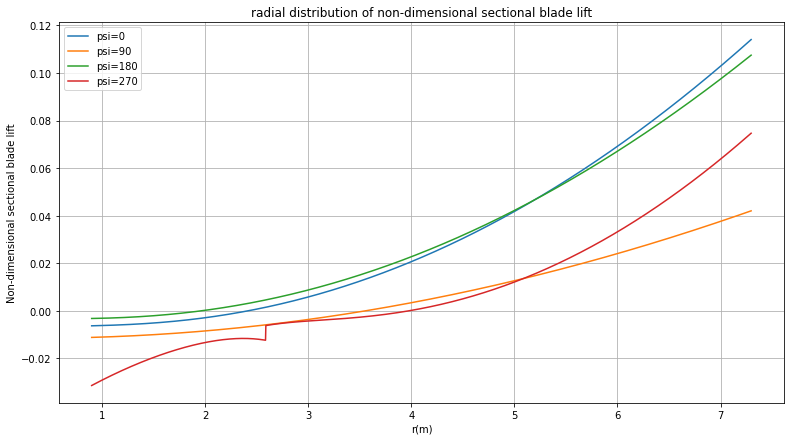

In [71]:
plt.figure(figsize=(13,7))
plt.plot(dr, radial_sectional_lift[0],label = "psi=0")
plt.plot(dr, radial_sectional_lift[1],label = "psi=90")
plt.plot(dr, radial_sectional_lift[2],label = "psi=180")
plt.plot(dr, radial_sectional_lift[3],label = "psi=270")
plt.legend()
plt.grid()
plt.xlabel("r(m)")
plt.ylabel("Non-dimensional sectional blade lift")
plt.title('radial distribution of non-dimensional sectional blade lift')
plt.savefig("plot_radial")

# Task3: Azimuthal variation of non-dimensional sectional blade lift

In [72]:
# sectional lift for given r/R value, return list of sectional lift at different psi
def find_azimuthal_sectional_lift(rbyR):
    azimuthal_lift_dpsi = np.zeros(len(dpsi))
    for i in range(len(dpsi)):
        azimuthal_lift_dpsi[i] = L_prime(rbyR*R,dpsi[i],beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw)/(rho*a*C*((omega*R)**2))
    return azimuthal_lift_dpsi
      

In [73]:
rbyR_list = [0.4,0.6,0.8,1]
azimuthal_sectional_lift=[]
for rbyR in rbyR_list:
    azimuthal_sectional_lift.append(find_azimuthal_sectional_lift(rbyR))

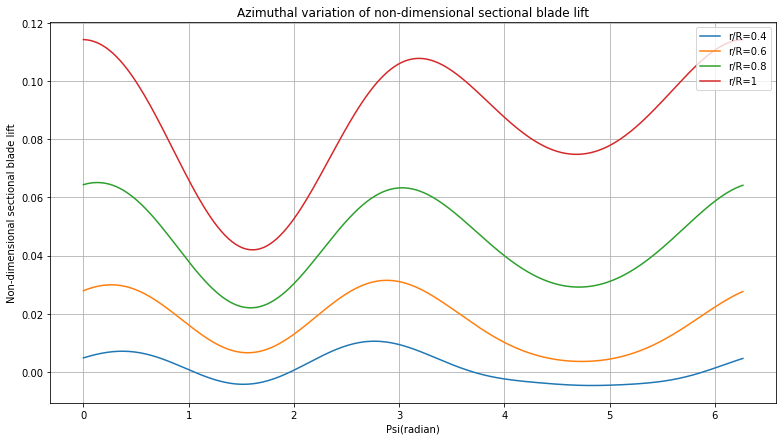

In [74]:
plt.figure(figsize=(13,7))
plt.plot(dpsi, azimuthal_sectional_lift[0],label = "r/R=0.4")
plt.plot(dpsi, azimuthal_sectional_lift[1],label = "r/R=0.6")
plt.plot(dpsi, azimuthal_sectional_lift[2],label = "r/R=0.8")
plt.plot(dpsi, azimuthal_sectional_lift[3],label = "r/R=1")
plt.legend()
plt.grid()
plt.xlabel("Psi(radian)")
plt.ylabel("Non-dimensional sectional blade lift")
plt.title('Azimuthal variation of non-dimensional sectional blade lift')
plt.savefig("plot_azimuth")

# If you want to try some other control value You can try this

In [78]:
# These are final trim values after optimization
beta_0 = 3
beta_1c = -1.07
beta_1s = 1.68
beta_0 = beta_0*np.pi/180
beta_1c = beta_1c*np.pi/180
beta_1s = beta_1s*np.pi/180

theta_0 = 18.7
theta_tw = -0.3
theta_1c = 2.1
theta_1s = -11.2
theta_0 = theta_0*np.pi/180
theta_tw = theta_tw*np.pi/180
theta_1c = theta_1c*np.pi/180
theta_1s = theta_1s*np.pi/180

In [79]:
Total_Thrust_Trim = blades*find_Thrust(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw)/(2*np.pi)
CT_Trim = Total_Thrust/(rho*(omega**2)*(R**4)*np.pi)
print('Total_Thrust_at Trim: ',Total_Thrust)
print('CT at Trim: ',CT_integrate)

Rolling_moment = blades*find_rolling_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw)/(2*np.pi)
C_rolling = Rolling_moment/(rho*(omega**2)*(R**5)*np.pi)
print('Rolling Moment at Trim: ',Rolling_moment)
print('Cm_rolling at Trim: ',C_rolling)

Pitching_moment = blades*find_pitching_moment(beta_0, beta_1c,beta_1s,theta_0, theta_1c, theta_1s,theta_tw)/(2*np.pi)
C_pitching = Pitching_moment/(rho*(omega**2)*(R**5)*np.pi)
print('Pitching Moment at Trim: ',Pitching_moment)
print('C_pitching at Trim: ',C_pitching)

Total_Thrust_at Trim:  83162.49352881065
CT at Trim:  0.010349180931778517
Rolling Moment at Trim:  -34.80656785539928
Cm_rolling at Trim:  -5.933580218293491e-07
Pitching Moment at Trim:  13.289264550257442
C_pitching at Trim:  2.265460862980337e-07


In [75]:
#Do not run this, This is for finding the trim value condition. It will take too much time. I have already run this
#function and reported the values.

In [76]:
@numba.njit
def find_params():
    params=[]
    CT_trim_find=[]
    CM_roll_find=[]
    CM_pitch_find=[]
    for i in beta_0_list:
        for j in beta_1c_list:
            for k in beta_1s_list:
                for l in theta_0_list:
                    for m in theta_tw_list:
                        for n in theta_1c_list:
                            for o in theta_1s_list:
                                beta_0 = i
                                beta_1c = j
                                beta_1s = k

                                # We have to find these values at trim conditions
                                theta_0 = l
                                theta_tw = m
                                theta_1c = n
                                theta_1s = o
                                params.append((i,j,k,l,m,n,o))
                                CT_tmp = (blades*find_Thrust())/(2*np.pi*(rho*(omega**2)*(R**4)*np.pi))
                                CM_roll_tmp= (blades*find_rolling_moment())/(2*np.pi*rho*(omega**2)*(R**5)*np.pi)
                                CM_pitch_tmp = (blades*find_pitching_moment())/(2*np.pi*rho*(omega**2)*(R**5)*np.pi)
                                CT_trim_find.append(CT_tmp)
                                CM_roll_find.append(CM_roll_tmp)
                                CM_pitch_find.append(CM_pitch_tmp)
        return params, CT_trim_find, CM_roll_find, CM_pitch_find

In [77]:
# params, CT_trim_find, CM_roll_find, CM_pitch_find = find_params()